<a href="https://colab.research.google.com/github/Zahab163/SMIT-FemHack-2026/blob/main/student_dropout_pipeline_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Student_dropout_pipeline:
In This LSTM



In [ ]:
 #Install libraries if needed
!pip install xgboost lightgbm

In [ ]:
# train_dropout_model.py
"""
Train a baseline ML model to predict student dropout risk
using the xAPI-Edu-Data dataset.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

import joblib
import kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aljarah/xAPI-Edu-Data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'xapi-edu-data' dataset.
Path to dataset files: /kaggle/input/xapi-edu-data


In [ ]:
# load_xapi_data.py
"""
Script to download and load the xAPI-Edu-Data dataset from Kaggle
and perform a quick exploration.
"""

import kagglehub
import pandas as pd

def load_xapi_data():
    # Download latest version of dataset
    path = kagglehub.dataset_download("aljarah/xAPI-Edu-Data")
    print("Dataset downloaded to:", path)



In [ ]:
df = pd.read_csv(path + '/xAPI-Edu-Data.csv')
df.head()


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [ ]:
# Quick exploration
print("\n--- Head of dataset ---")
print(df.head())



--- Head of dataset ---
  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Y

In [ ]:
print("\n--- Info ---")
print(df.info())




--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  Parentschool

In [ ]:
print("\n--- Target distribution ---")
print(df['Class'].value_counts())




--- Target distribution ---
Class
M    211
H    142
L    127
Name: count, dtype: int64


In [ ]:
# Map target variable
# Class column has: L = Low, M = Middle, H = High (risk levels)
# If you want binary dropout vs continue, map accordingly:
df["Dropout"] = df["Class"].apply(lambda x: 1 if x=="L" else 0)



In [ ]:
#cleaning feature (changing into numeric)
df["StudentAbsenceDays"] = df["StudentAbsenceDays"].map({"Under-7":0, "Above-7":1})

In [ ]:
#- Fill missing categorical values (though your dataset looks complete):
categorical_cols = df.select_dtypes(include="object").columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")






In [ ]:
#  Define target
y = df["Class"]
X = df.drop(columns=["Class"])


In [ ]:
# Handle categorical values
categorical_cols = df.select_dtypes(include="object").columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")



In [ ]:
# Numeric columns
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


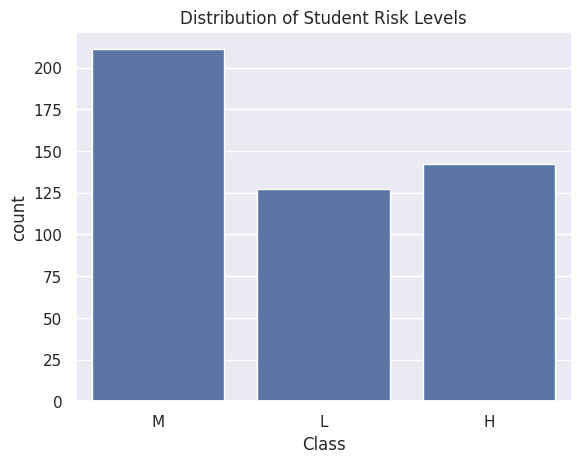

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
seaborn = sns.set_theme()

#  Distribution of target
sns.countplot(x="Class", data=df)
plt.title("Distribution of Student Risk Levels")
plt.show()



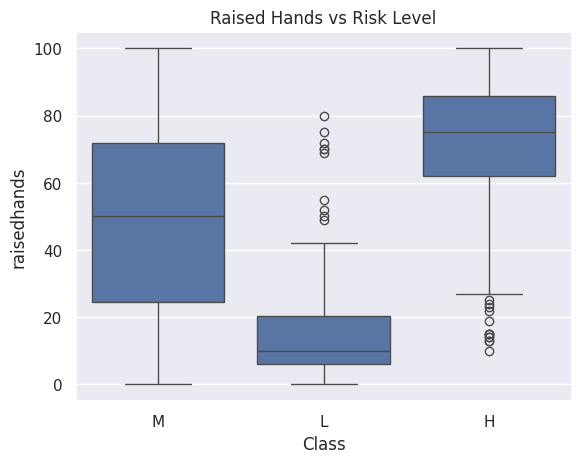

In [ ]:
# Raised hands vs dropout
sns.boxplot(x="Class", y="raisedhands", data=df)
plt.title("Raised Hands vs Risk Level")
plt.show()



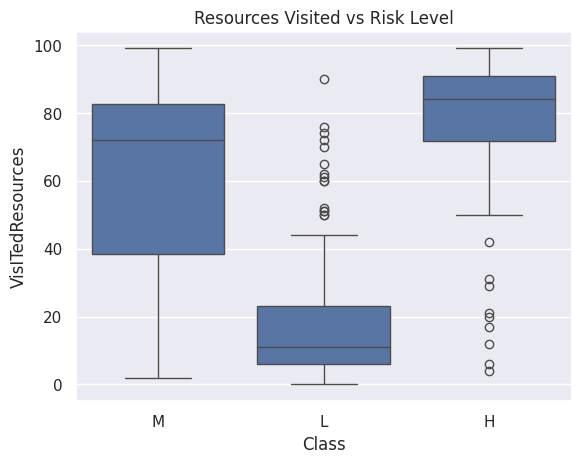

In [ ]:
#Resources visited vs dropout
sns.boxplot(x="Class", y="VisITedResources", data=df)
plt.title("Resources Visited vs Risk Level")
plt.show()


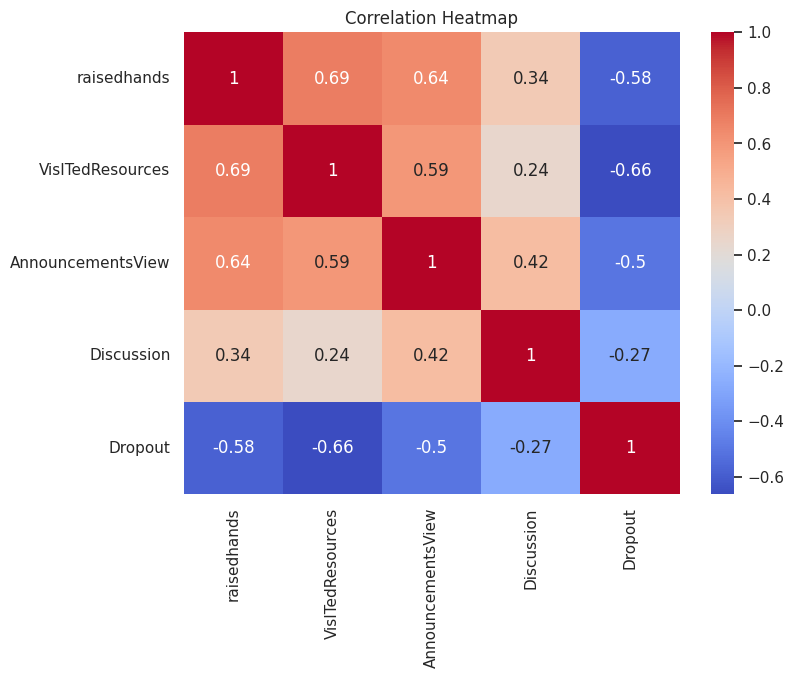

In [ ]:
# Correlation heatmap (numeric features)
plt.figure(figsize=(8,6))
sns.heatmap(df[["raisedhands","VisITedResources","AnnouncementsView","Discussion","Dropout"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Example: encode a single column 'Gender' with values 'M'/'F'
encoder = LabelEncoder()
X['Gender'] = encoder.fit_transform(X['Gender'])

KeyError: 'Gender'

In [ ]:
#Use OneHotEncoder for multiple categorical columns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify actual categorical and numeric columns from DataFrame X
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [ ]:
#  Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)


In [ ]:
# 5. Build pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])


In [ ]:
# 2. Redefine target to include at least two classes
y = df["Class"].apply(lambda x: 1 if x == "L" else 0)  # Assuming 'L' represents the positive class (e.g., dropout)
X = df.drop(columns=["Class"])

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'NationalITy',
                                                   'PlaceofBirth', 'StageID',
                                                   'GradeID', 'SectionID',
                                                   'Topic', 'Semester',
                                                   'Relation',
                                                   'ParentAnsweringSurvey',
                                                   'ParentschoolSatisfaction']),
                                                 ('num', StandardScaler(),
                                                  ['raisedhands',
                                                   'VisITedResources',
                                                   'AnnouncementsView',
                                                   'Discussion',
                                                   'StudentAbsenceDays',
                                                   'Dropout'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# 8. Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        25

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

ROC-AUC: 1.0


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline for Random Forest, reusing the preprocessor
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 1.0


In [ ]:
# XGBoost
# Create a pipeline for XGBoost, reusing the preprocessor
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:56:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#Support Vector Machine
# Create a pipeline for SVM, reusing the preprocessor
svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel='rbf', probability=True, random_state=42)) # Added random_state for reproducibility
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 1.0


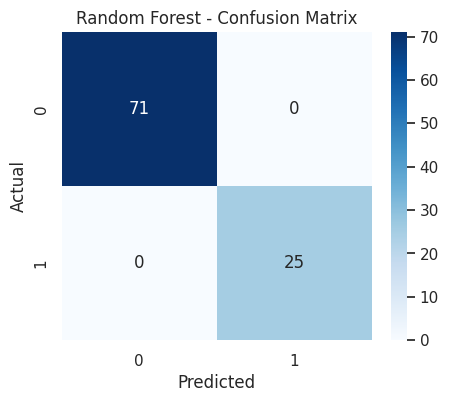


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        25

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



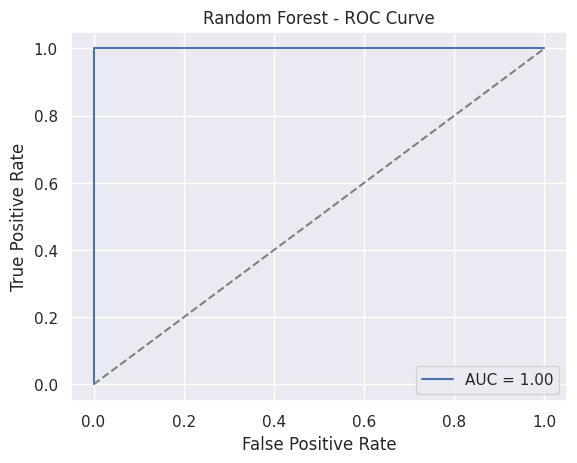

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"\n{model_name} - Classification Report")
    print(classification_report(y_test, y_pred))

    # ROC Curve (binary classification only)
    if len(set(y_test)) == 2:
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

# Example usage with Random Forest
rf_pipeline.fit(X_train, y_train)
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

# Repeat for other models:
# evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
# evaluate_model(xgb_model, X_test, y_test, "XGBoost")
# evaluate_model(lgb_model, X_test, y_test, "LightGBM")
# evaluate_model(svm, X_test, y_test, "SVM")

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train.shape[1])))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.layers import Input

lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X_train.shape[1])))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# LSTM for sequential data
# Only useful if your dataset is time-series/sequential
# Example with dummy reshaping

# Apply the preprocessor to transform X_train and X_test into numerical arrays
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrix to dense array before reshaping for LSTM
X_train_processed_dense = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
X_test_processed_dense = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed

# Reshape the processed NumPy arrays for LSTM
X_seq = X_train_processed_dense.reshape((X_train_processed_dense.shape[0], 1, X_train_processed_dense.shape[1]))
X_seq_test = X_test_processed_dense.reshape((X_test_processed_dense.shape[0], 1, X_test_processed_dense.shape[1]))
from tensorflow.keras.layers import Input

lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X_train_processed_dense.shape[1])))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',   # what to monitor (can also use 'val_accuracy')
    patience=3,           # number of epochs with no improvement before stopping
    restore_best_weights=True # roll back to the best model weights
)

# Fit model with early stopping
history = lstm_model.fit(
    X_seq, y_train,
    validation_data=(X_seq_test, y_test),
    epochs=50,            # set a higher max epoch, early stopping will cut it short
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]
)




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=3,               # stop after 3 epochs with no improvement
    restore_best_weights=True # roll back to best weights
)

checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.h5', # file to save the best model
    monitor='val_loss',
    save_best_only=True,      # only save when val_loss improves
    verbose=1
)

# Train with callbacks
history = lstm_model.fit(
    X_seq, y_train,
    validation_data=(X_seq_test, y_test),
    epochs=50,                # set high, early stopping will cut it short
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, checkpoint]
)


Epoch 1: val_loss improved from inf to 0.00526, saving model to best_lstm_model.h5



Epoch 2: val_loss improved from 0.00526 to 0.00508, saving model to best_lstm_model.h5



Epoch 3: val_loss improved from 0.00508 to 0.00490, saving model to best_lstm_model.h5



Epoch 4: val_loss improved from 0.00490 to 0.00476, saving model to best_lstm_model.h5



Epoch 5: val_loss improved from 0.00476 to 0.00461, saving model to best_lstm_model.h5



Epoch 6: val_loss improved from 0.00461 to 0.00450, saving model to best_lstm_model.h5



Epoch 7: val_loss improved from 0.00450 to 0.00436, saving model to best_lstm_model.h5



Epoch 8: val_loss improved from 0.00436 to 0.00430, saving model to best_lstm_model.h5



Epoch 9: val_loss improved from 0.00430 to 0.00417, saving model to best_lstm_model.h5



Epoch 10: val_loss improved from 0.00417 to 0.00404, saving model to best_lstm_model.h5



Epoch 11: val_loss improved from 0.00404 to 0.00396, saving model to best_lstm_model.h5



Epoch 12: val_loss improved from 0.00396 to 0.00383, saving model to best_lstm_model.h5



Epoch 13: val_loss improved from 0.00383 to 0.00374, saving model to best_lstm_model.h5



Epoch 14: val_loss improved from 0.00374 to 0.00368, saving model to best_lstm_model.h5



Epoch 15: val_loss improved from 0.00368 to 0.00358, saving model to best_lstm_model.h5



Epoch 16: val_loss improved from 0.00358 to 0.00350, saving model to best_lstm_model.h5



Epoch 17: val_loss improved from 0.00350 to 0.00345, saving model to best_lstm_model.h5



Epoch 18: val_loss improved from 0.00345 to 0.00334, saving model to best_lstm_model.h5



Epoch 19: val_loss improved from 0.00334 to 0.00328, saving model to best_lstm_model.h5



Epoch 20: val_loss improved from 0.00328 to 0.00319, saving model to best_lstm_model.h5



Epoch 21: val_loss improved from 0.00319 to 0.00314, saving model to best_lstm_model.h5



Epoch 22: val_loss improved from 0.00314 to 0.00305, saving model to best_lstm_model.h5



Epoch 23: val_loss improved from 0.00305 to 0.00301, saving model to best_lstm_model.h5



Epoch 24: val_loss improved from 0.00301 to 0.00294, saving model to best_lstm_model.h5



Epoch 25: val_loss improved from 0.00294 to 0.00286, saving model to best_lstm_model.h5



Epoch 26: val_loss improved from 0.00286 to 0.00282, saving model to best_lstm_model.h5



Epoch 27: val_loss improved from 0.00282 to 0.00275, saving model to best_lstm_model.h5



Epoch 28: val_loss improved from 0.00275 to 0.00274, saving model to best_lstm_model.h5



Epoch 29: val_loss improved from 0.00274 to 0.00267, saving model to best_lstm_model.h5



Epoch 30: val_loss improved from 0.00267 to 0.00262, saving model to best_lstm_model.h5



Epoch 31: val_loss improved from 0.00262 to 0.00257, saving model to best_lstm_model.h5



Epoch 32: val_loss improved from 0.00257 to 0.00252, saving model to best_lstm_model.h5



Epoch 33: val_loss improved from 0.00252 to 0.00249, saving model to best_lstm_model.h5



Epoch 34: val_loss improved from 0.00249 to 0.00243, saving model to best_lstm_model.h5



Epoch 35: val_loss improved from 0.00243 to 0.00239, saving model to best_lstm_model.h5



Epoch 36: val_loss improved from 0.00239 to 0.00234, saving model to best_lstm_model.h5



Epoch 37: val_loss improved from 0.00234 to 0.00231, saving model to best_lstm_model.h5



Epoch 38: val_loss improved from 0.00231 to 0.00227, saving model to best_lstm_model.h5



Epoch 39: val_loss improved from 0.00227 to 0.00223, saving model to best_lstm_model.h5



Epoch 40: val_loss improved from 0.00223 to 0.00219, saving model to best_lstm_model.h5



Epoch 41: val_loss improved from 0.00219 to 0.00215, saving model to best_lstm_model.h5



Epoch 42: val_loss improved from 0.00215 to 0.00211, saving model to best_lstm_model.h5



Epoch 43: val_loss improved from 0.00211 to 0.00208, saving model to best_lstm_model.h5



Epoch 44: val_loss improved from 0.00208 to 0.00204, saving model to best_lstm_model.h5



Epoch 45: val_loss improved from 0.00204 to 0.00202, saving model to best_lstm_model.h5



Epoch 46: val_loss improved from 0.00202 to 0.00200, saving model to best_lstm_model.h5



Epoch 47: val_loss improved from 0.00200 to 0.00197, saving model to best_lstm_model.h5



Epoch 48: val_loss improved from 0.00197 to 0.00192, saving model to best_lstm_model.h5



Epoch 49: val_loss improved from 0.00192 to 0.00189, saving model to best_lstm_model.h5



Epoch 50: val_loss improved from 0.00189 to 0.00187, saving model to best_lstm_model.h5


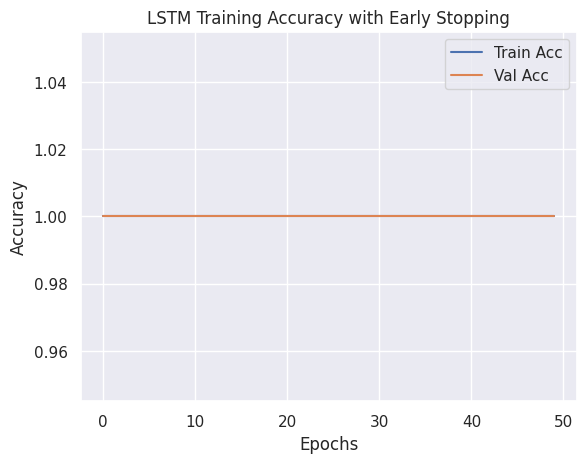

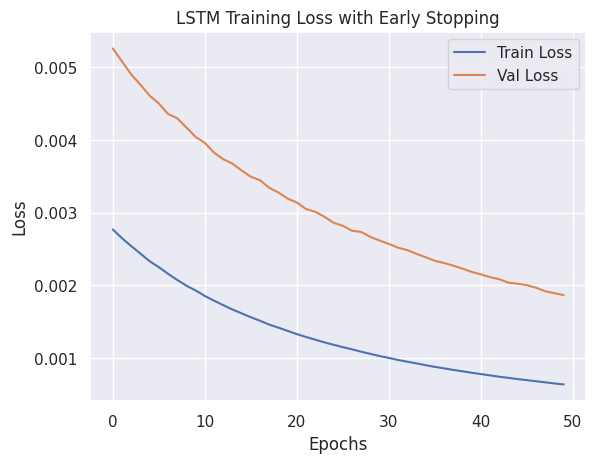

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("LSTM Training Accuracy with Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Training Loss with Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

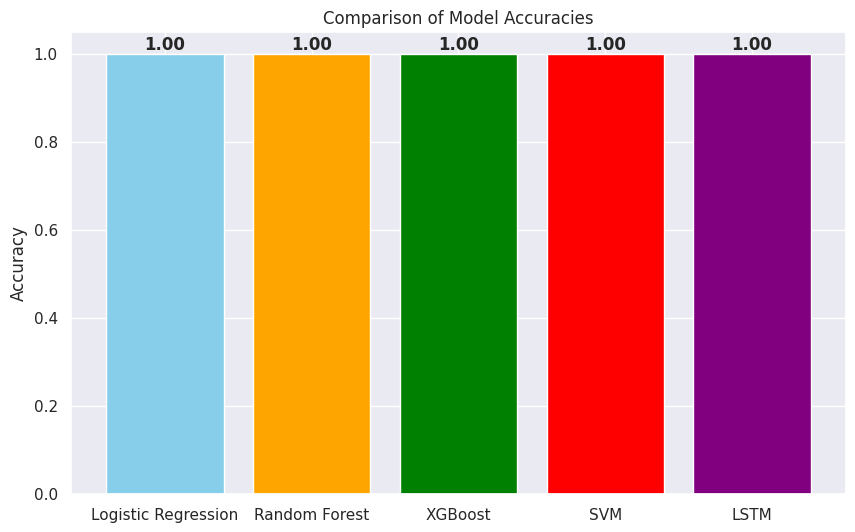

In [ ]:
# Evaluate models and store accuracies
accuracy_dict = {
    "Logistic Regression": model.score(X_test, y_test),
    "Random Forest": rf_pipeline.score(X_test, y_test),
    "XGBoost": xgb_pipeline.score(X_test, y_test),
    "SVM": svm_pipeline.score(X_test, y_test),
    "LSTM": acc # 'acc' is already defined from the last LSTM evaluation
}

plt.figure(figsize=(10,6))
plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=['skyblue','orange','green','red', 'purple'])
plt.ylim(0, 1.05) # Adjust ylim to give some space above the highest bar
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
for i, v in enumerate(accuracy_dict.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 


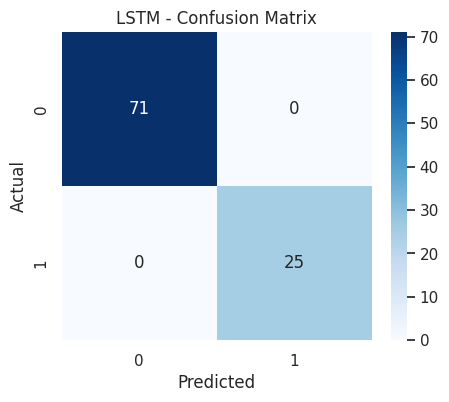

LSTM - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        25

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


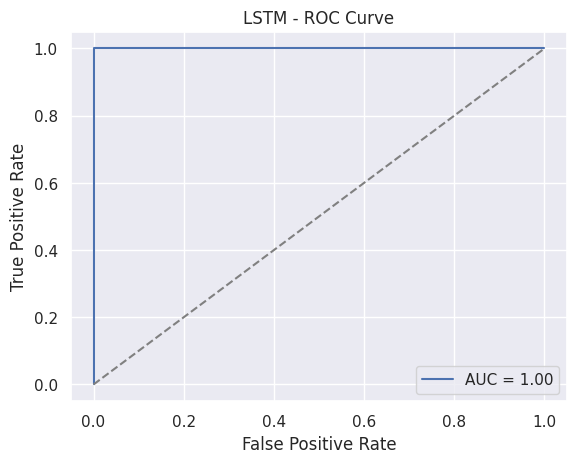

In [ ]:
# Predictions
y_pred_lstm = (lstm_model.predict(X_seq_test) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("LSTM - Classification Report")
print(classification_report(y_test, y_pred_lstm))

# ROC Curve
y_prob_lstm = lstm_model.predict(X_seq_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("LSTM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# The best model is saved as best_lstm_model.h5.
# You can reload it later without retraining:
from tensorflow.keras.models import load_model
best_lstm = load_model('best_lstm_model.h5')
loss, acc = best_lstm.evaluate(X_seq_test, y_test, verbose=0)
print("Best LSTM Accuracy:", acc)






Best LSTM Accuracy: 1.0


In [ ]:
# 9. Save model + pipeline
joblib.dump(model, "dropout_model.pkl")


['dropout_model.pkl']

In [ ]:
# 10. Generate predictions file
results = pd.DataFrame({
    "student_id": X_test.index,
    "risk_score": y_prob,
    "risk_label": pd.cut(y_prob, bins=[0,0.3,0.6,1], labels=["Low","Medium","High"]),
    "predicted_dropout": y_pred
})

results.to_csv("dropout_pipeline.csv", index=False)
print("Predictions saved to dropout_pipeline.csv")

Predictions saved to dropout_pipeline.csv
